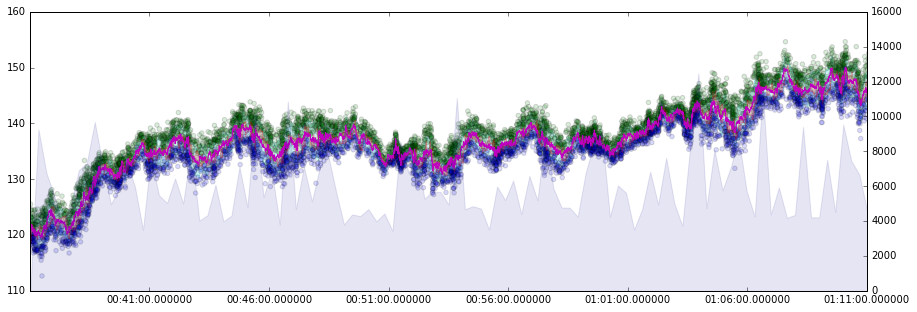

In [9]:
from itertools import islice, izip
from server import *

hist = list(islice(market(datetime.now()), 0, 8000))

def bucket(tdelta, series):
    t0, y = None, 0
    for t, yy in series:
        if not t0 or t0 + tdelta < t:
            t0 = t
            yield t0, y
            y = 0
        y = y + yy

def _plot_orders(hist):
    %matplotlib inline

    import matplotlib.pyplot as plt
    ts, pxs, spd = zip(*hist)
    ts, sides, ords, sizes = zip(*list(orders(hist)))
    ts = list(ts)
  
    ts, bids, asks = zip(*order_book(zip(ts, sides, ords, sizes), dict()))
    top_buy, top_sell = zip(*top(bids, asks))
    fig, ax1 = plt.subplots(figsize = (15, 5))
    
    ax1.plot(ts, pxs, 'm')
    bids =  map(lambda (idx, px): px - spd[idx] / 2, enumerate(pxs))
    asks =  map(lambda (idx, px): px + spd[idx] / 2, enumerate(pxs))
    ax1.fill_between(ts, bids, asks, color = 'c', alpha = 0.2)

    ax1.scatter(ts, ords, c = map(lambda x: 'b' if x == 'buy' else 'g', sides), alpha = 0.15)
    
    ax1.fill_between(ts, map(lambda x: x or 120, top_buy), map(lambda x: x or 120, top_sell), color='r', alpha = 0.2)
 

    ts, sizes = zip(*bucket(timedelta(seconds = 20), zip(ts, sizes)))
    ax2 = ax1.twinx()
    ax2.fill_between(ts, sizes, alpha = 0.1, color = 'darkblue')

    
    ax1.axis([ts[0], ts[-1], None, None])
    ax2.axis([ts[0], ts[-1], 0, 16000])
    plt.show()
    
_plot_orders(hist)